In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

from matplotlib.colors import to_rgb, CSS4_COLORS, TABLEAU_COLORS, BASE_COLORS
from tqdm import trange, tqdm
from imageio import imread, imsave
from skimage.measure import label, regionprops
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import threshold_otsu

In [3]:
def argmax(arr):
    s = {}
    for a in arr: 
        if a:
            if str(a) in s.keys(): s[str(a)] += 1
            else: s[str(a)] = 1
    mx = 0
    ans = [0, 0, 0]
    for i in s.keys():
        if s[i] > mx:
            mx = s[i]
            ans = list(map(float, i[1:-1].split(', ')))
    return ans
def neighbours(x, y, img):
    deep = 5
    vars = [[i, j] for i in range(-deep, deep + 1) for j in range(-deep, deep + 1)]
    ans = []
    for dx, dy in vars:
        xn, yn = x + dx, y + dy
        if xn >= 0 and xn < len(img) and yn >= 0 and yn < len(img[0]):
            ans.append(img[xn][yn])
    return ans

C:\Users\user\AppData\Local\Temp\ipykernel_17920\553579033.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('gen.png')


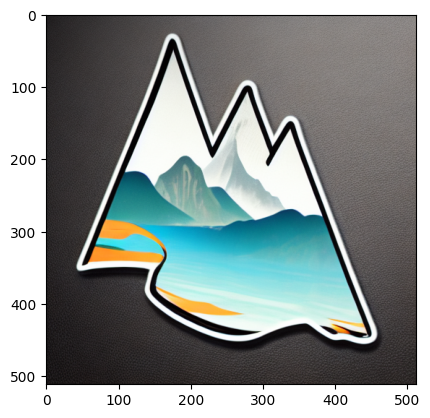

In [4]:
img = imread('gen.png')
plt.imshow(img)

In [5]:
r, vis, b = [img[:, :, i] for i in range(3)]

In [6]:
t = r < threshold_otsu(r)
lb = label(t)
big1 = lb == 1
big2 = lb == 0

s1 = big1[0].sum() + big1[-1].sum() + big1[:, 0].sum() + big1[:, -1].sum()
s2 = big2[0].sum() + big2[-1].sum() + big2[:, 0].sum() + big2[:, -1].sum()

if s1 > s2:
    msk = lb == 1
else:
    msk = lb == 0

newmsk = np.zeros((512, 512, 3))
newmsk[~msk, :] = 1
newmsk = newmsk.astype('bool')

In [7]:
img[~newmsk] = 0

In [8]:
img = rgb2hsv(img)

In [9]:
clrs = {}
dsv = 0.3
dhue = 0.1
for clr in CSS4_COLORS.keys():
    val = rgb2hsv(np.array(to_rgb(clr)))
    # minval = val.copy()
    # minval[0] -= dhue
    # minval[1] -= dsv
    # minval[2] -= dsv
    # mxval = val.copy()
    # mxval[0] += dhue
    # mxval[1] += dsv
    # mxval[2] += dsv
    clrs[clr] = val

In [10]:
@nb.njit
def mark(img, its):
    nimg = np.zeros((512, 512, 3))
    for i in nb.prange(img.shape[0]):
        for j in nb.prange(img.shape[1]):
            px = img[i, j]
            if (px == np.array([0, 0, 0], dtype='float64')).sum() != 3:
                mv = 1e9
                for clr in its:
                    if np.abs(clr[1] - px).sum() < mv:
                        mv = np.abs(clr[1] - px).sum()
                        mn = clr[1]
                nimg[i, j] = mn
    return nimg

In [11]:
its = list(clrs.items())
nimg = mark(img, its)
nimg = hsv2rgb(nimg)

d:\Soft\anaconda3\envs\artist\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'its' of function 'mark'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\user\AppData\Local\Temp\ipykernel_17920\418244956.py", line 2:
@nb.njit
def mark(img, its):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


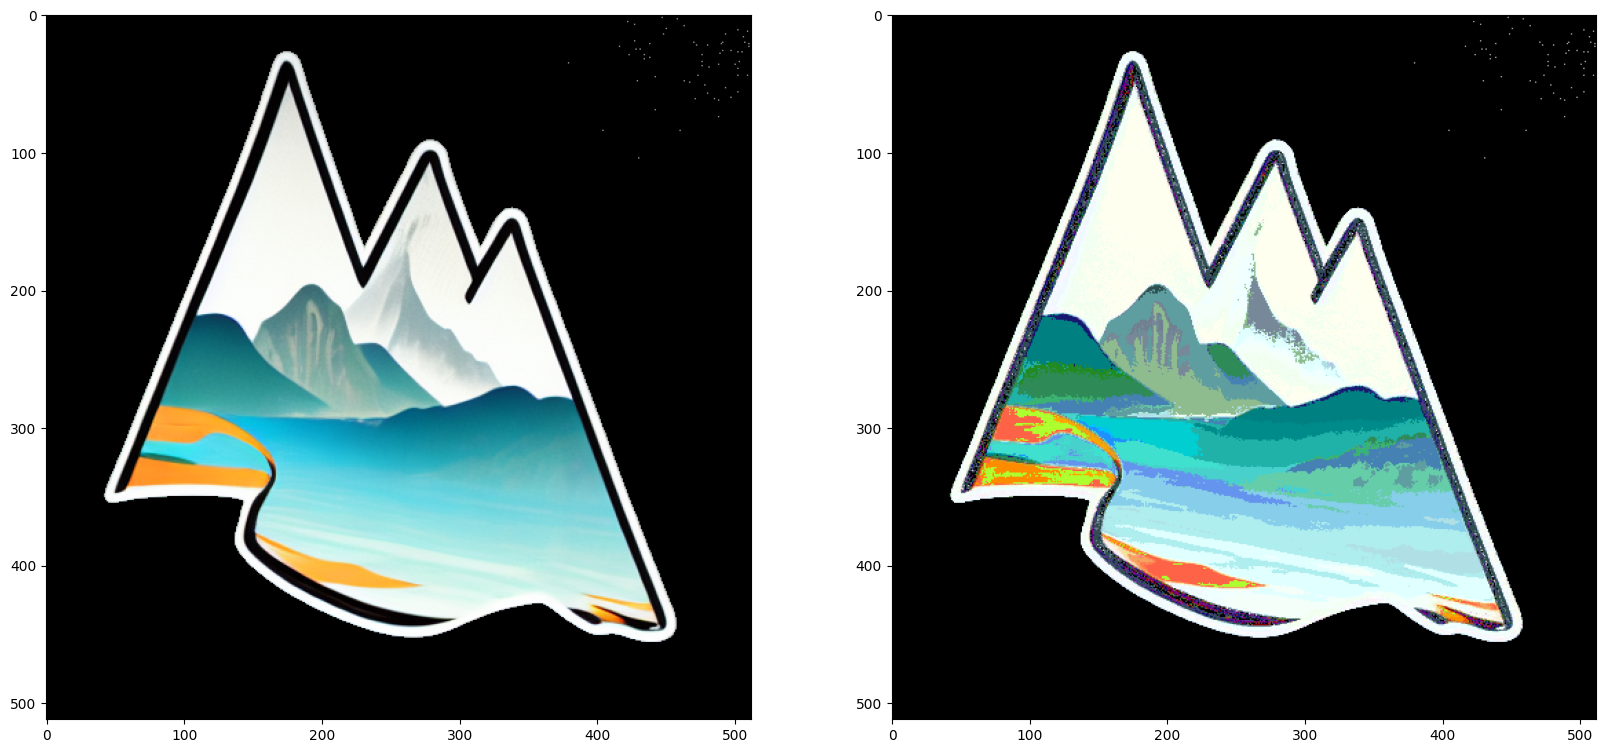

In [12]:
f, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(hsv2rgb(img))
ax[1].imshow(nimg)

In [22]:
nnimg = nimg.copy()
cnt = 0
for color in tqdm(its):
    color = color[1]
    f = nnimg == color
    if len(np.unique(f)) == 1: continue
    f = f[:, :, 0]
    lbs = label(f)
    regp = regionprops(lbs)
    for reg in regp:
        mnr, mnc, mxr, mxc = reg.bbox
        w, h = mxr - mnr, mxc - mnc
        if min(w, h) < 30:
            cnt += 1
            for cord in reg.coords:
                nnimg[cord[0], cord[1]] = -1

100%|██████████| 148/148 [00:01<00:00, 78.53it/s]


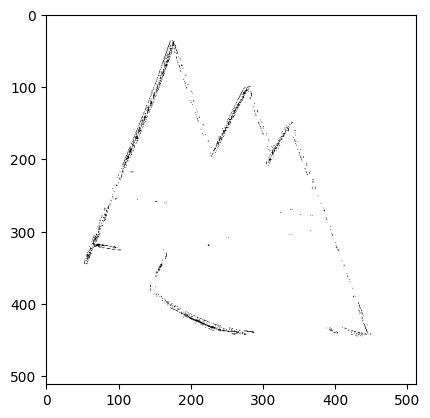

In [23]:
plt.imshow((nnimg != -1)[:, :, 0], cmap='gray')

In [15]:
def check(x, y, shape):
    if x >= 0 and y >= 0 and x < shape[0] and y < shape[1]:
        return True
    return False

In [16]:
n = 1
var = [[i, j] for i in range(-n, n + 1) for j in range(-n, n + 1) if not(i == 0 and j == 0)]

In [17]:
vis = nnimg != -1
vis = vis[:, :, 0]

In [18]:
def bfs(x, y):
    global vis, nnimg, var
    vis1 = vis.copy()
    vis[x, y] = 1
    ln = [[x, y, 0, [0, 0, 0]]]
    while len(ln) != 0:
        for x, y, flg, clr in ln[:]:
            ln.pop(0)
            for dx, dy in var:
                xn, yn = x + dx, y + dy
                if check(xn, yn, nnimg.shape):
                    if flg: 
                        nnimg[xn, yn] = clr
                        if not vis1[xn, yn]:
                            ln.append([xn, yn, flg, clr])
                            vis1[xn, yn] = 1
                    elif (nnimg[xn, yn] == (0, 0, 0)).sum() != 3:
                        clr = nnimg[xn, yn]
                        flg = 1
                        ln.append([x, y, flg, clr])
                        vis1[x, y] = 1
                    elif not vis[xn, yn]:
                        vis[xn, yn] = 1
                        ln.append([xn, yn, flg, clr])

In [19]:
for i in trange(nnimg.shape[0]):
    for j in range(nnimg.shape[1]):
        if not vis[i, j]:
            bfs(i, j)

100%|██████████| 512/512 [00:00<00:00, 1348.69it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


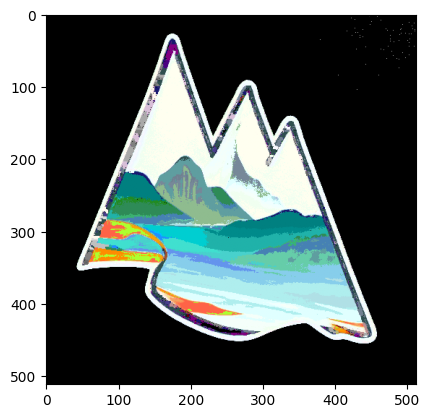

In [20]:
plt.imshow(nnimg)